# Extração

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
)

In [2]:
url = 'https://raw.githubusercontent.com/emilibohrer/telecom-x/main/TelecomX_Dados_Limpos.csv'
df = pd.read_csv(url, sep=',', encoding='utf-8')

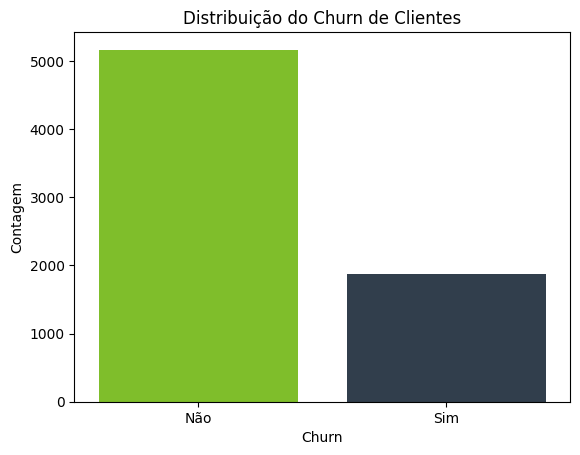

In [3]:
color_dict = {1: "#2C3E50", 0: "#82D712"}

ax = sns.countplot(x="churn", hue="churn", data=df, palette=color_dict, legend=False)

ax.set_title("Distribuição do Churn de Clientes")
ax.set_xlabel("Churn")
ax.set_ylabel("Contagem")
ax.set_xticks([0, 1])
ax.set_xticklabels(["Não", "Sim"])

plt.savefig('img/distribuicao_churn.png', dpi=300, bbox_inches='tight')
plt.show()

In [4]:
x = df.drop("churn", axis=1)
y = df["churn"]

colunas = x.columns

# Transformando a variável alvo

In [5]:
label_ecoder = LabelEncoder()
y = label_ecoder.fit_transform(y)

# Tranformando as variáveis explicativas

In [6]:
colunas_categoricas = [
    "protecao_aparelho",
    "contrato",
    "filmes_streaming",
    "tv_streaming",
    "suporte_tecnico",
    "backup_online",
    "seguranca_online",
    "servico_internet",
    "multiplas_linhas",
    "genero",
    "servico_telefone",
    "fatura_digital",
    "dependentes",
    "tem_conjuge",
    "idoso",
    "metodo_pagamento"
]

In [7]:
one_hot = make_column_transformer(
    (
        OneHotEncoder(drop="if_binary"),
        colunas_categoricas,
    ),
    remainder="passthrough",
    sparse_threshold=0,
)

In [8]:
x = one_hot.fit_transform(x)

# Balanceando base

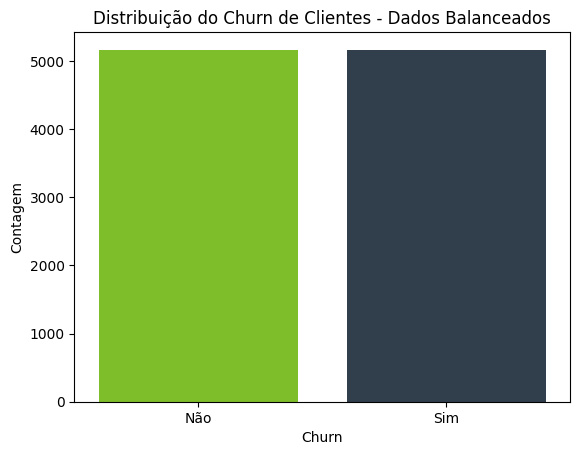

In [9]:
smt = SMOTE(random_state=20)
x_balanceado, y_balanceado = smt.fit_resample(x, y)

x_balanceado = pd.DataFrame(x_balanceado, columns=one_hot.get_feature_names_out(colunas))
y_balanceado = pd.Series(y_balanceado, name="churn")

df_dados_balanceados = pd.concat([x_balanceado, y_balanceado], axis=1)


color_dict = {1: "#2C3E50", 0: "#82D712"}

ax = sns.countplot(
    x="churn", hue="churn", data=df_dados_balanceados, palette=color_dict, legend=False
)
ax.set_title("Distribuição do Churn de Clientes - Dados Balanceados")
ax.set_xlabel("Churn")
ax.set_ylabel("Contagem")
ax.set_xticks([0, 1])
ax.set_xticklabels(["Não", "Sim"])

plt.savefig('img/distribuicao_churn_balanceado.png', dpi=300, bbox_inches='tight')
plt.show()

x = df_dados_balanceados.drop("churn", axis=1)
y = df_dados_balanceados["churn"]
colunas = x.columns

# Correlação

In [10]:
X = df_dados_balanceados.drop(columns="churn")

vif_dados = pd.DataFrame()
vif_dados["feature"] = X.columns

vif_dados["VIF"] = [
    variance_inflation_factor(X.values, i) for i in range(len(X.columns))
]

vif_dados.sort_values("VIF", ascending=True).head(10)

C:\Users\emili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
27,onehotencoder__genero_Masculino,1.003685
32,onehotencoder__idoso_1,1.161779
29,onehotencoder__fatura_digital_1,1.231053
30,onehotencoder__dependentes_1,1.396052
31,onehotencoder__tem_conjuge_1,1.480198
37,remainder__tempo_de_contrato,8.896549
39,remainder__cobranca_total,10.854874
34,onehotencoder__metodo_pagamento_Cheque eletronico,inf
35,onehotencoder__metodo_pagamento_Cheque enviado...,inf
21,onehotencoder__servico_internet_DSL,inf


In [11]:
colunas_relevantes = [
    "onehotencoder__genero_Masculino",
    "onehotencoder__idoso_1",
    "onehotencoder__fatura_digital_1",
    "onehotencoder__dependentes_1",
    "onehotencoder__tem_conjuge_1",
    "remainder__tempo_de_contrato",
    "remainder__cobranca_total",
]

In [12]:
df_col_relevants = df_dados_balanceados[colunas_relevantes + ["churn"]]

x = df_col_relevants.drop("churn", axis=1)
y = df_col_relevants["churn"]
colunas = x.columns

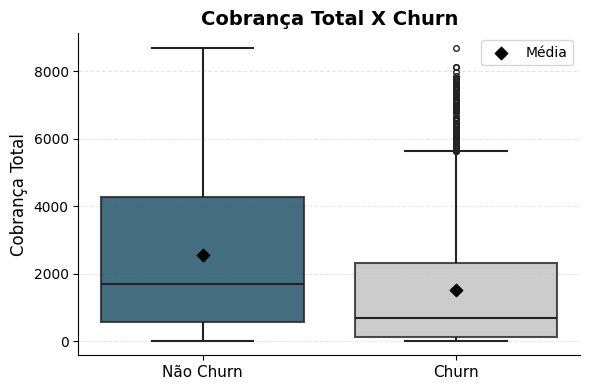

In [13]:
def plot_boxplot(df_base, x, y, titulo, label, cores, titulo_name=None):
    """
    Gera um boxplot comparando a distribuição de uma variável numérica entre clientes com e sem churn.

    Parâmetros:
    - df_base (DataFrame): Conjunto de dados contendo a coluna 'churn', além das colunas especificadas.
    - x (str): Nome da coluna categórica usada no eixo X (geralmente mesmo valor para todos).
    - y (str): Nome da variável numérica a ser analisada.
    - titulo (str): Título do gráfico.
    - label (str): Nome do eixo Y (label da variável numérica).
    - cores (list): Lista de cores para representar os grupos (ex: ['#00C49A', '#FF4444'] para Não Churn e Churn).

    Funcionamento:
    - Cria um boxplot dividido por churn para mostrar a distribuição da variável numérica.
    - Calcula as médias e medianas e insere marcadores de média visualmente.
    - Customiza os elementos visuais, como grid, títulos, legendas e eixos.

    Observações:
    - A coluna 'churn' deve conter os valores 0 e 1.
    """
    # Define o tamanho da figura do gráfico
    plt.figure(figsize=(6, 4))

    # Cria o boxplot com separação por churn (hue)
    sns.boxplot(
        x=x,                  # variável categórica no eixo X
        y=y,                  # variável numérica a ser visualizada
        hue='churn',          # separa por churn: 0 (Não churn) ou 1 (Churn)
        data=df_base,
        palette=cores,        
        linewidth=1.5,        
        fliersize=4,          
        boxprops=dict(alpha=0.8),  
        legend=False          # desativa a legenda automática
    )

    # Calcula a média e mediana da variável para churn e não churn
    medias = df_base.groupby('churn')[y].mean()
    medianas = df_base.groupby('churn')[y].median()

    # Plota a média como marcador extra por cima do boxplot
    for i in range(2):  # churn: 0 ou 1
        plt.scatter(
            i, medias[i], 
            color='black', marker='D', s=40, 
            zorder=5, label='Média' if i == 0 else ""
        )

    # Define título e rótulo dos eixos
    plt.title(titulo, fontsize=14, weight='bold')
    plt.xlabel('')
    plt.ylabel(label, fontsize=12)

    # Ajusta os rótulos do eixo X manualmente
    plt.xticks([0, 1], ['Não Churn', 'Churn'], fontsize=11)

    # Remove bordas e adiciona grade suave
    sns.despine()
    plt.grid(axis='y', linestyle='--', alpha=0.3)

    # Adiciona legenda no canto superior direito
    plt.legend(loc='upper right')

    # Ajusta o layout e exibe o gráfico
    plt.tight_layout()

    plt.savefig(f'img/{titulo_name}.png', dpi=300, bbox_inches='tight')
    plt.show()

# cores = [ '#757575','#2E2E2E' ]
cores = [ '#084D6E', '#C0C0C0',]

x_plot = 'churn'
y_plot = 'cobranca_total'
titulo = 'Cobrança Total X Churn'
label = 'Cobrança Total'

plot_boxplot(df, x_plot, y_plot, titulo, label, cores, titulo_name='cobranca_total_churn')

Observações
- Clientes que não cancelaram (Não Churn) tendem a ter valores de cobrança total mais altos.
- Clientes que permanecem mais tempo acumulam maiores cobranças — o que pode indicar maior valor para a empresa.
- O grupo "Churn" apresenta uma distribuição mais concentrada em valores mais baixos, com menos outliers.

RESUMO
- Clientes com baixa cobrança total podem estar em risco de cancelamento.

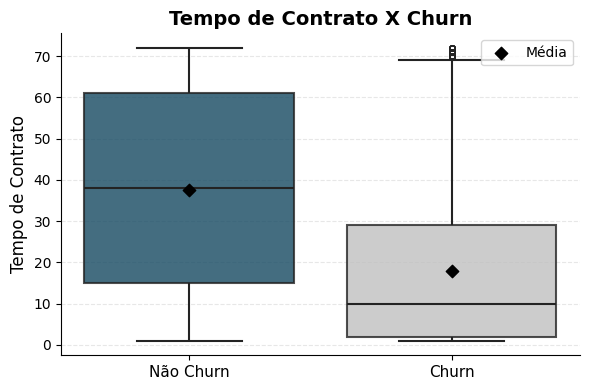

In [14]:
cores = [ '#084D6E', '#C0C0C0',]

x_plot = 'churn'
y_plot = 'tempo_de_contrato'
titulo = 'Tempo de Contrato X Churn'
label = 'Tempo de Contrato'

plot_boxplot(df, x_plot, y_plot, titulo, label, cores, titulo_name='tempo_contrato_churn')

Observações
- Em média, os clientes que não cancelam têm contratos mais longos.
- Há maior variabilidade no tempo de contrato entre os clientes que cancelam.
- A média do tempo de contrato também é maior no grupo "Não Churn", reforçando a tendência.

RESUMO
- Clientes com contratos mais curtos têm maior probabilidade de cancelar.
- O tempo de contrato pode ser um indicador importante para prever o churn.

# Normalização

In [15]:
colunas_numericas = ["remainder__tempo_de_contrato", "remainder__cobranca_total"]

In [16]:
norm = StandardScaler()

x_normalizado = norm.fit_transform(x[colunas_numericas])
x[colunas_numericas] = x_normalizado

In [17]:
df_normalizado = pd.concat([x, y], axis=1)
x_normalizado = df_normalizado.drop("churn", axis=1)
y_normalizado = df_normalizado["churn"]
colunas = x.columns

# Treino vs Teste

In [18]:
percent_teste = 0.3
SEED = 42

x_treino_norm, x_teste_norm, y_treino_norm, y_teste_norm = train_test_split(
    x_normalizado, y_normalizado, stratify=y, test_size=percent_teste, random_state=SEED
)

x_treino_bal, x_teste_bal, y_treino_bal, y_teste_bal = train_test_split(
    x, y, stratify=y, test_size=percent_teste, random_state=SEED
)

print(f"Divisão dos dados: {int(percent_teste*100)}% para teste e {int(100 - percent_teste*100)}% para treino")
print("TREINO: %d elementos \n TESTE: %d elementos"% (len(x_treino_norm), len(x_teste_norm)))

Divisão dos dados: 30% para teste e 70% para treino
TREINO: 7228 elementos 
 TESTE: 3098 elementos


# Modelos

In [19]:
def avaliar_modelos(nome, y_test, y_pred):
    print(f"\n=== {nome} ===")
    print("Acurácia:", round(accuracy_score(y_test, y_pred), 3))
    print("Precisão:", round(precision_score(y_test, y_pred), 3))
    print("Recall:", round(recall_score(y_test, y_pred), 3))
    print("F1-score:", round(f1_score(y_test, y_pred), 3))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriz de Confusão - {nome}")
    plt.xlabel("Previsto")
    plt.ylabel("Real")
    plt.show()

## Modelo: Regressão Logística

In [20]:
# Regressão Logística (dados balanceados e normalizados)
modelo_regressao_log = LogisticRegression(max_iter=1000, random_state=42)
modelo_regressao_log.fit(x_treino_norm, y_treino_norm)
y_pred_regressao_log = modelo_regressao_log.predict(x_teste_norm)
y_proba_regressao_log = modelo_regressao_log.predict_proba(x_teste_norm)[:, 1]

Relatório - Regressão Logística
              precision    recall  f1-score   support

           0       0.79      0.69      0.73      1549
           1       0.72      0.81      0.76      1549

    accuracy                           0.75      3098
   macro avg       0.75      0.75      0.75      3098
weighted avg       0.75      0.75      0.75      3098

AUC-ROC: 0.8241844527029871

=== Regressão Logística ===
Acurácia: 0.75
Precisão: 0.722
Recall: 0.813
F1-score: 0.765


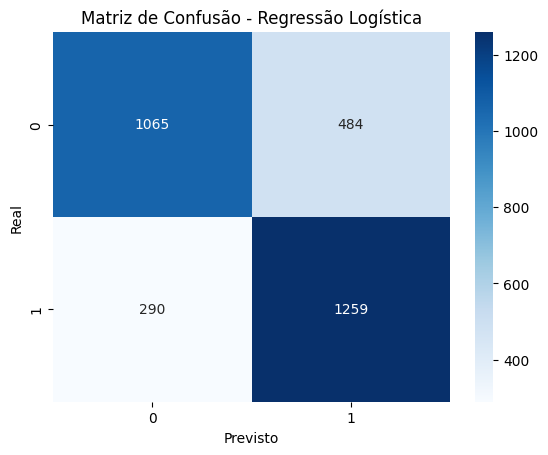

In [21]:
y_teste = y_teste_norm
y_predito = y_pred_regressao_log
y_proba = y_proba_regressao_log
modelo = "Regressão Logística"

print(f"Relatório - {modelo}")
print(classification_report(y_teste, y_predito))
print("AUC-ROC:", roc_auc_score(y_teste, y_proba))
avaliar_modelos(f"{modelo}", y_teste, y_predito)

- **Precisão**: Para a classe 0 (não churn), o modelo é mais preciso (79%) — ou seja, quando prevê negativo, está certo com mais frequência. Para a classe 1 (churn), a precisão é menor (72%), indicando mais falsos positivos.
- **Recall**: O modelo tem um bom recall para os cliente que cancelaram os serviços (81%), o que significa que ele consegue identificar bem os casos positivos. Já para cliente que permaneceram, o recall é mais baixo (69%), indicando que muitos negativos estão sendo classificados erroneamente como positivos.
- **F1-score**: A média harmônica entre precisão e recall mostra que o modelo tem desempenho equilibrado, com 0.73 para cliente que permaneceram e 0.76 para clientes que cancelaram os serviços.


- **Acurácia**: 75% — o modelo acerta 3 em cada 4 previsões.
- **AUC-ROC**: 0.82 — excelente! Isso mostra que o modelo tem uma boa capacidade de discriminar entre as classes.
- **Média ponderada das métricas**: Todas em torno de 0.75, o que reforça a consistência do modelo.


**Falsos positivos (484)**: Casos negativos classificados como positivos.  
**Falsos negativos (290)**: Casos positivos classificados como negativos.

O modelo tem mais dificuldade em evitar falsos positivos do que falsos negativos, o que pode ser relevante dependendo do contexto (por exemplo, em diagnósticos médicos, falsos negativos podem ser mais críticos).


O modelo de `regressão logística` está bem calibrado, com bom desempenho geral e excelente capacidade de separação entre classes (AUC). Ele favorece a detecção de positivos (classe 1 - churn), o que pode ser útil em cenários onde é mais importante identificar casos positivos mesmo que isso gere alguns falsos alarmes.

## Modelo: Random Forest

In [22]:
modelo_rf = RandomForestClassifier(random_state=42, max_depth=5)
modelo_rf.fit(x_treino_bal, y_treino_bal)
y_pred_rf = modelo_rf.predict(x_teste_bal)
y_proba_rf = modelo_rf.predict_proba(x_teste_bal)[:, 1]

Relatório - Random Forest
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1549
           1       0.82      0.83      0.82      1549

    accuracy                           0.82      3098
   macro avg       0.82      0.82      0.82      3098
weighted avg       0.82      0.82      0.82      3098

AUC-ROC: 0.9046478683638125

=== Random Forest ===
Acurácia: 0.824
Precisão: 0.824
Recall: 0.825
F1-score: 0.825


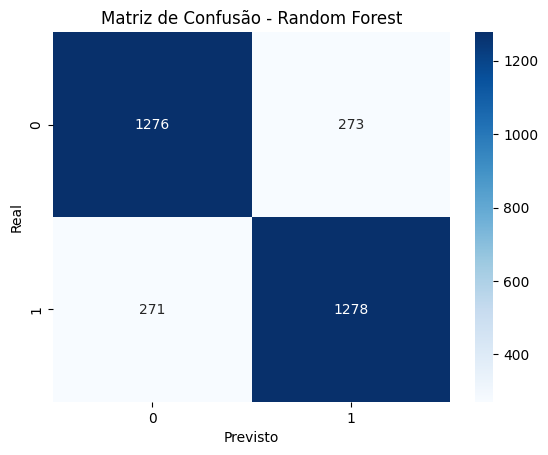

In [23]:
y_teste = y_teste_bal
y_predito = y_pred_rf
y_proba = y_proba_rf
modelo = "Random Forest"

print(f"Relatório - {modelo}")
print(classification_report(y_teste, y_predito))
print("AUC-ROC:", roc_auc_score(y_teste, y_proba))
avaliar_modelos(f"{modelo}", y_teste, y_predito)

- **Precisão**: O modelo acerta 82% das vezes quando prevê cada classe — isso mostra consistência.
- **Recall**: Também em torno de 82–83%, indicando que o modelo consegue identificar bem os casos positivos e negativos.
- **F1-score**: Excelente equilíbrio entre precisão e recall para ambas as classes.

- **Acurácia**: 82.4% — melhor que o modelo de regressão logística (75%).
- **AUC-ROC**: 0.9046 — muito bom! Isso indica que o modelo tem alta capacidade de distinguir entre as classes, com menos sobreposição entre os scores preditivos.


**Falsos positivos (273)** e **falsos negativos (271)** estão bem equilibrados.

O modelo erra em cerca de 17.6% dos casos, mas os erros são distribuídos de forma simétrica entre as classes.

O Random Forest se destaca por:
- Desempenho superior à regressão logística em todas as métricas.
- Equilíbrio entre classes, o que é ótimo para problemas onde ambas as classes são igualmente importantes.
- Alta AUC-ROC, sugerindo excelente separação entre os grupos.

# Análises

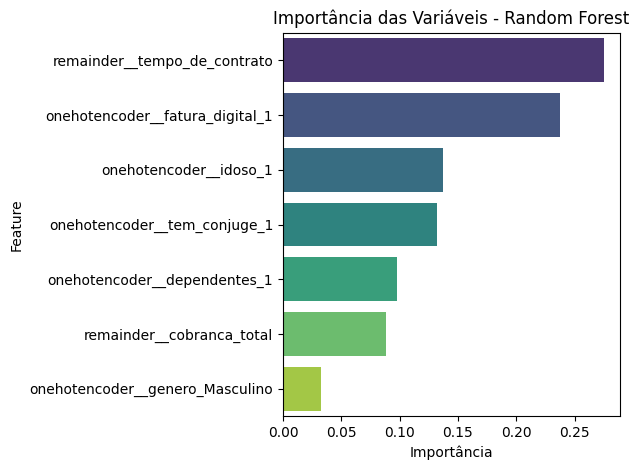

In [24]:
variaveis_importantes = pd.DataFrame(
    {"Feature": colunas, "Importância": modelo_rf.feature_importances_}
)
variaveis_importantes.sort_values(by="Importância", ascending=False, inplace=True)

sns.barplot(
    data=variaveis_importantes,
    x="Importância",
    y="Feature",
    hue="Feature",
    palette="viridis",
    legend=False,
)
plt.title("Importância das Variáveis - Random Forest")
plt.tight_layout()

plt.savefig(f'img/rd_variaveis.png', dpi=300, bbox_inches='tight')
plt.show()

IMPORTÂNCIA DAS VARIÁVEIS

`tempo_de_contrato`: Altíssima importância, reforçando o papel do tempo de contrato na retenção.  
`cobranca_total`: Também muito relevante, indicando que valores altos de cobrança estão associados ao churn.  
`fatura_digital`: Importante para o modelo, sugerindo que o método de recebimento da fatura influencia a evasão.  
`idoso`, `dependentes`, `tem_conjuge`: Todas aparecem entre as mais relevantes, alinhando-se com os resultados da regressão logística.

In [25]:
coef_regressao_log = pd.DataFrame({
    'feature': x_treino_norm.columns,
    'coeficiente': modelo_regressao_log.coef_[0]
})

coef_regressao_log['abs_coef'] = coef_regressao_log['coeficiente'].abs()
coef_regressao_log = coef_regressao_log.sort_values(by='abs_coef', ascending=False)

print("Variáveis mais relevantes - Regressão Logística:")
print(coef_regressao_log[['feature', 'coeficiente']])

Variáveis mais relevantes - Regressão Logística:
                           feature  coeficiente
5     remainder__tempo_de_contrato    -2.511658
6        remainder__cobranca_total     1.528867
2  onehotencoder__fatura_digital_1     0.837263
1           onehotencoder__idoso_1     0.835703
3     onehotencoder__dependentes_1    -0.348092
0  onehotencoder__genero_Masculino    -0.006404
4     onehotencoder__tem_conjuge_1     0.002767


ANÁLISE DOS COEFICIENTES

`tempo_de_contrato`: Coeficiente negativo, indicando que clientes com maior tempo de contrato têm menor probabilidade de camcelamento.  
`cobranca_total`: Coeficiente positivo, sugerindo que cobranças totais mais altas aumentam a chance de churn.  
`fatura_digital`: Coeficiente positivo, indicando que clientes que recebem fatura digital tendem a evadir mais.  
`idoso`: Coeficiente negativo, mostrando que idosos têm menor propensão ao churn.  
`dependentes` e `tem_conjuge`: Ambos negativos, sugerindo que clientes com dependentes ou cônjuge são mais fiéis.  

# Relatório Final

### Principais Fatores que influenciam o churn (cancelamento)

A análise dos modelos revela os principais fatores associados ao churn:

- **Tempo de contrato**: Clientes com contratos mais longos demonstram maior propensão à permanência.
- **Valor total cobrado**: Cobranças elevadas aumentam significativamente o risco de churn.
- **Fatura digital**: O recebimento de faturas digitais está correlacionado com maior taxa de churn.
- **Faixa etária e contexto familiar**: Idosos e clientes com dependentes ou cônjuge apresentam menor tendência à churn.

---

### Estratégias recomendadas para retenção de clientes

Com base nos resultados obtidos, recomenda-se:

- **Oferecer benefícios para contratos mais longos**  
  Incentivar a renovação e extensão contratual por meio de vantagens exclusivas.

- **Revisar políticas de cobrança**  
  Avaliar a justificativa de cobranças elevadas e propor descontos ou planos personalizados para clientes com maior valor de fatura.

- **Acompanhar clientes que recebem fatura digital**  
  Implementar campanhas de engajamento e oferecer suporte proativo a esse grupo, visando aumentar a satisfação e reduzir o churn.

- **Valorizar perfis familiares**  
  Criar programas de fidelidade voltados a idosos e clientes com dependentes, reconhecendo e reforçando sua lealdade.

---

### Conclusão

Os modelos analisados apontam fatores **financeiros** e **contexto familiar** como os principais influenciadores de churn.  
Para mitigar o churn, é essencial adotar estratégias que envolvam:

- Incentivo à permanência por meio de contratos mais longos.  
- Flexibilização das políticas de cobrança.  
- Atendimento personalizado e segmentado, especialmente para grupos com maior risco identificado.

Essas ações podem fortalecer o relacionamento com o cliente e aumentar a retenção de forma sustentável.